In [1]:
try:
    from astra.torch.models import ResNetClassifier
    print('installed')
except:
    print('not installed')
    pass
#     %pip install git+https://github.com/sustainability-lab/ASTRA

installed


[Reference Notebook](https://github.com/nipunbatra/pml-teaching/blob/master/notebooks/ssl.ipynb)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier
from astra.torch.al import Furthest, Centroid, DiversityStrategy

# Netron, ONNX for model visualization
import netron
import onnx


/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jaiswalsuraj/suraj_work/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/jaiswalsuraj/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.cuda.get_device_name(device)

/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


(device(type='cuda'), 'NVIDIA A100-SXM4-80GB')

# Dataset

In [4]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified


Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

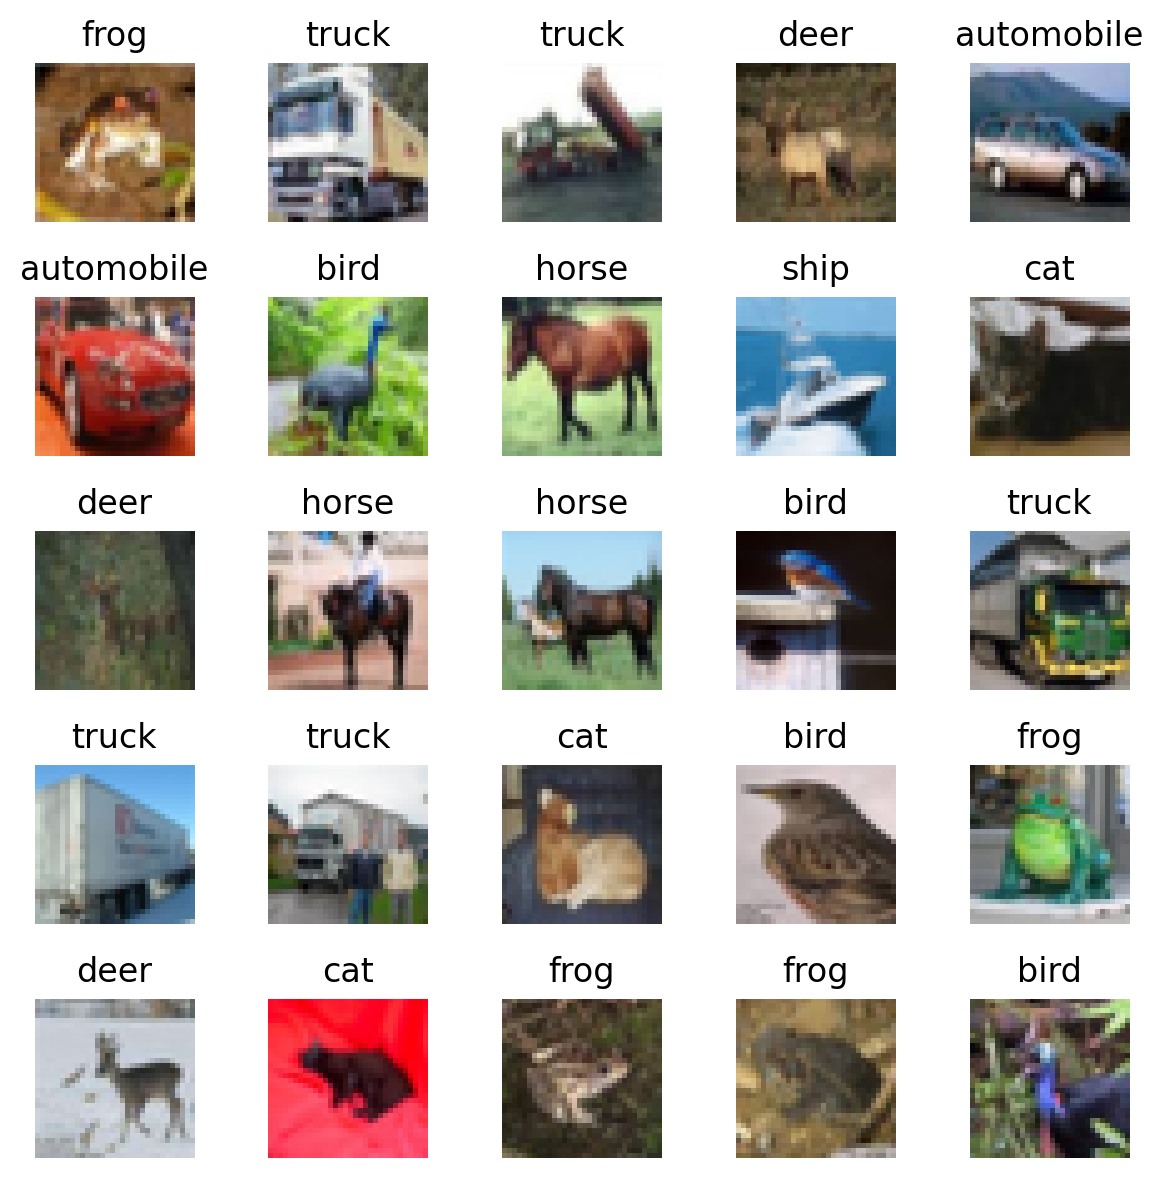

In [5]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

# Train val test split

In [6]:
n_train = 1000
n_test = 20000

X = dataset.data.to(device)
y = dataset.targets.to(device)

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0., device='cuda:0') tensor(1., device='cuda:0')
torch.Size([60000]) torch.int64


In [7]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


# Checking out untrained model

In [8]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

In [9]:
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [10]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [11]:
# Export to ONNX and visualize with Netron
dummy_input = torch.randn(1, 3, 32, 32).to(device)
# torch.onnx.export(resnet, dummy_input, "resnet.onnx", verbose=True)
# netron.start("resnet.onnx")

train set accuracy: 7.70%


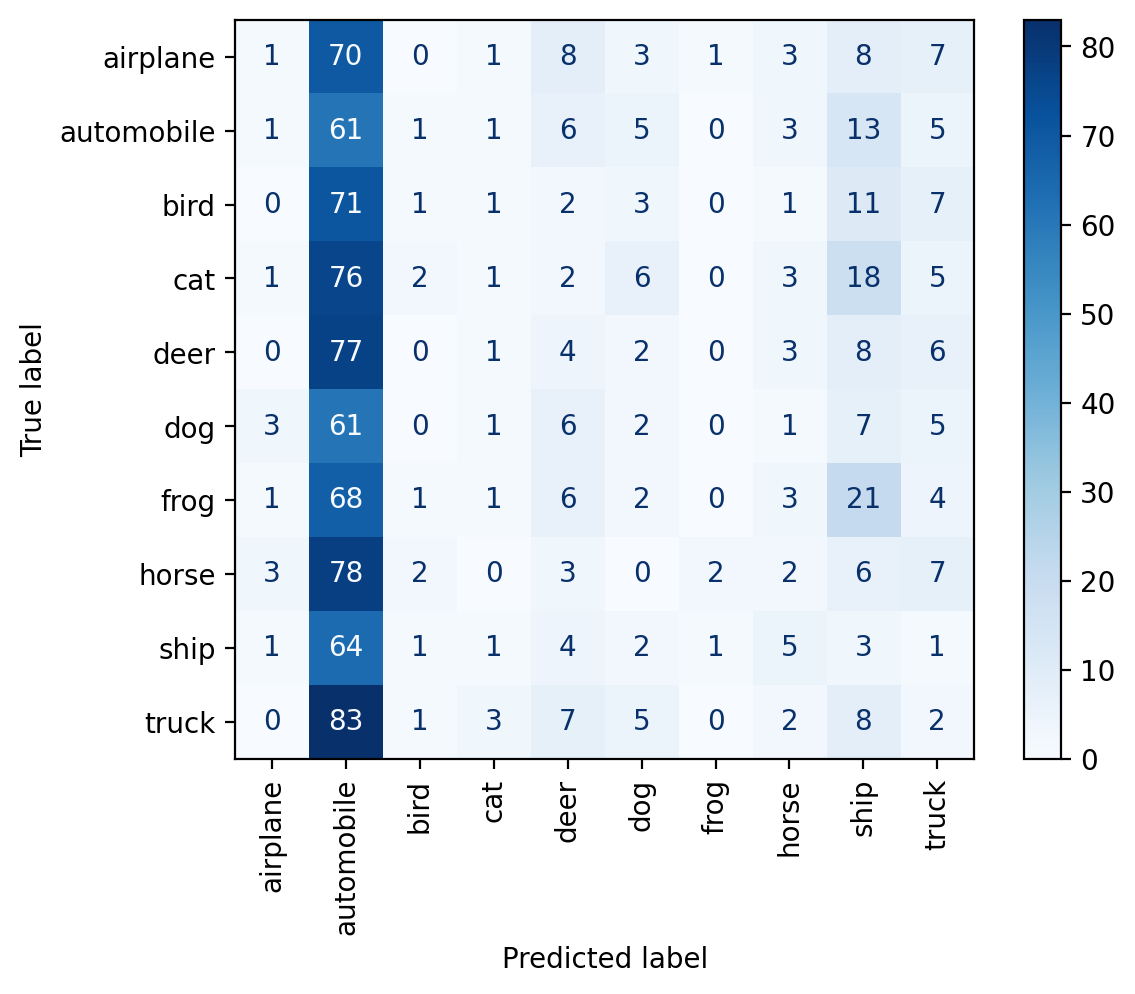

pool set accuracy: 8.37%


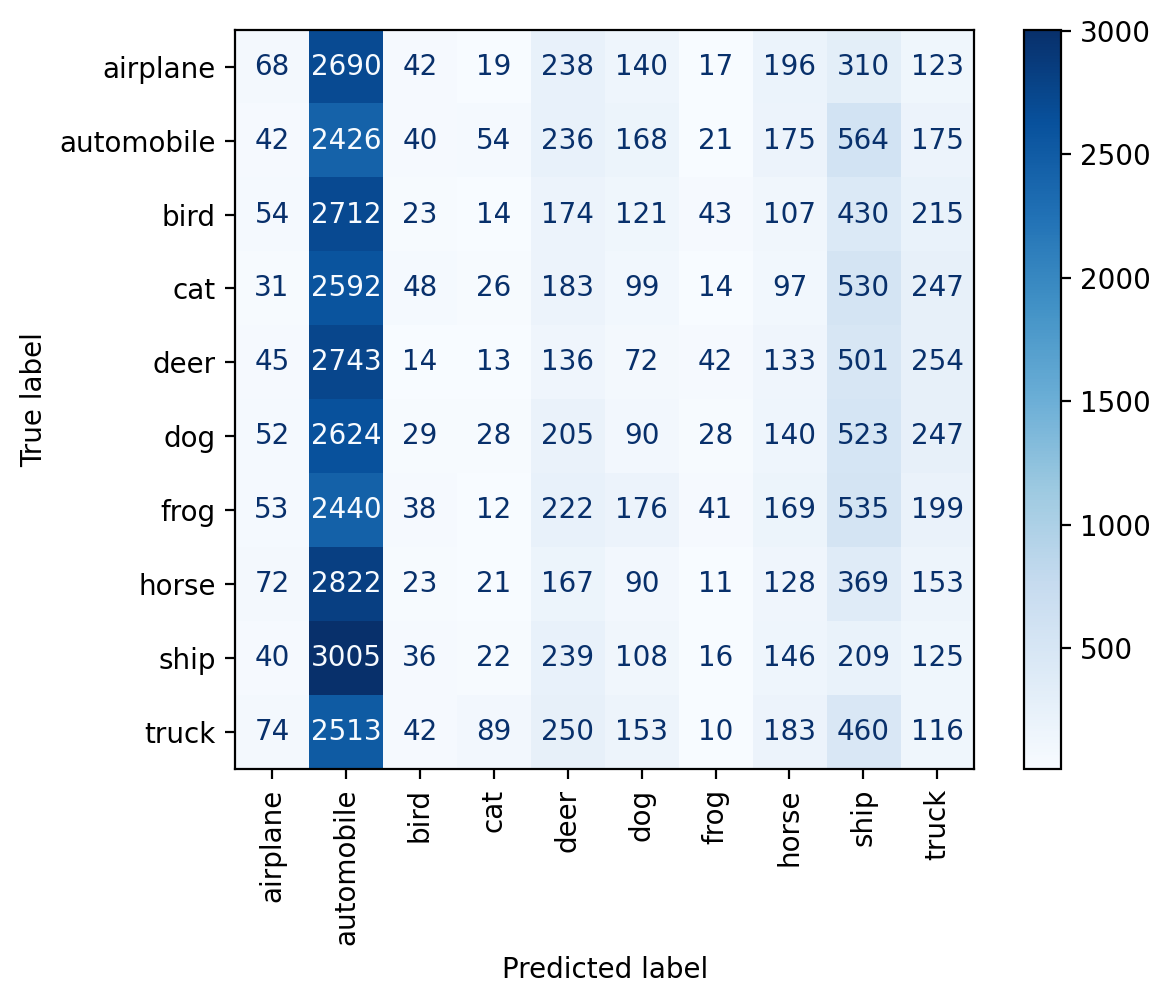

test set accuracy: 8.58%


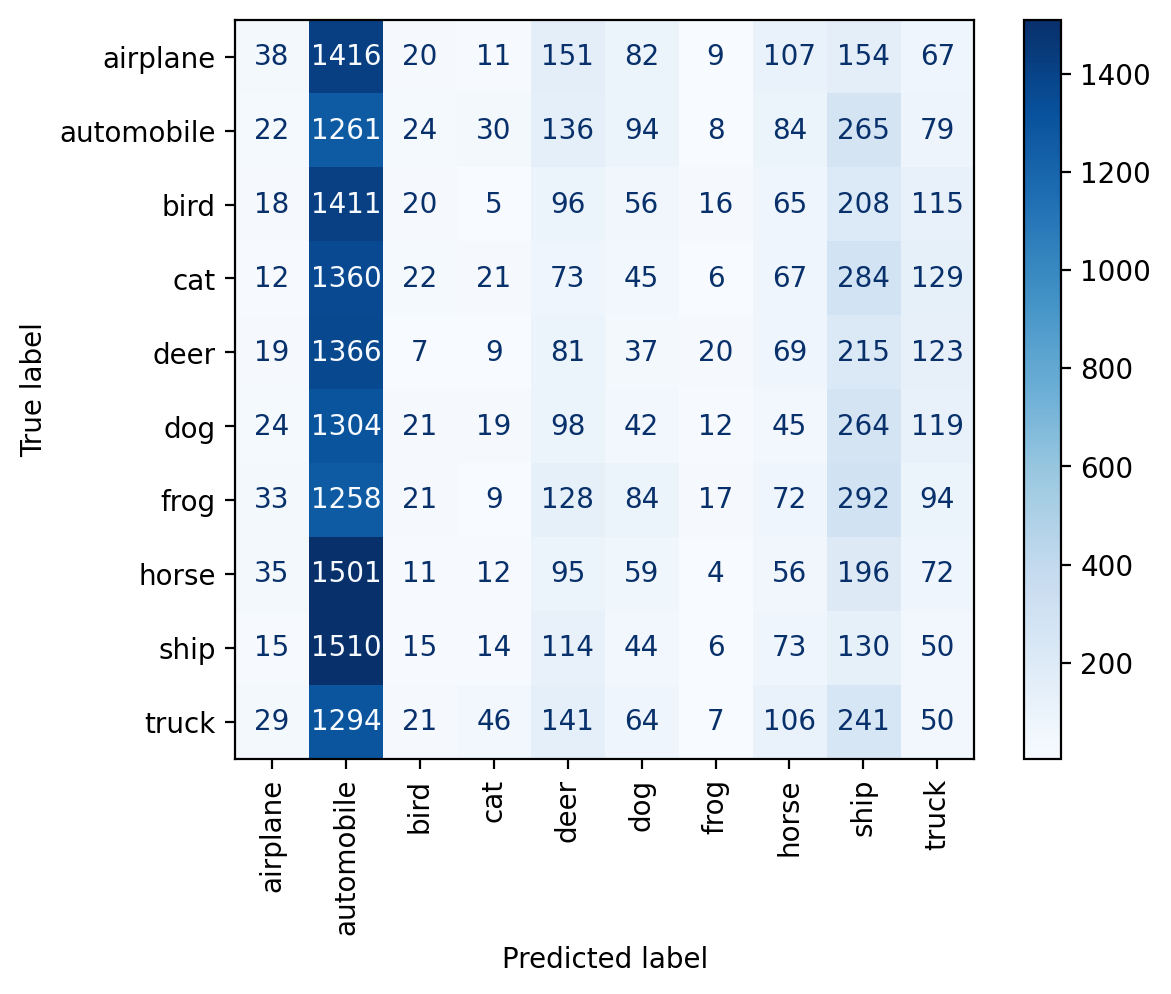

In [12]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()

predict(resnet, dataset.classes, plot_confusion_matrix=True)

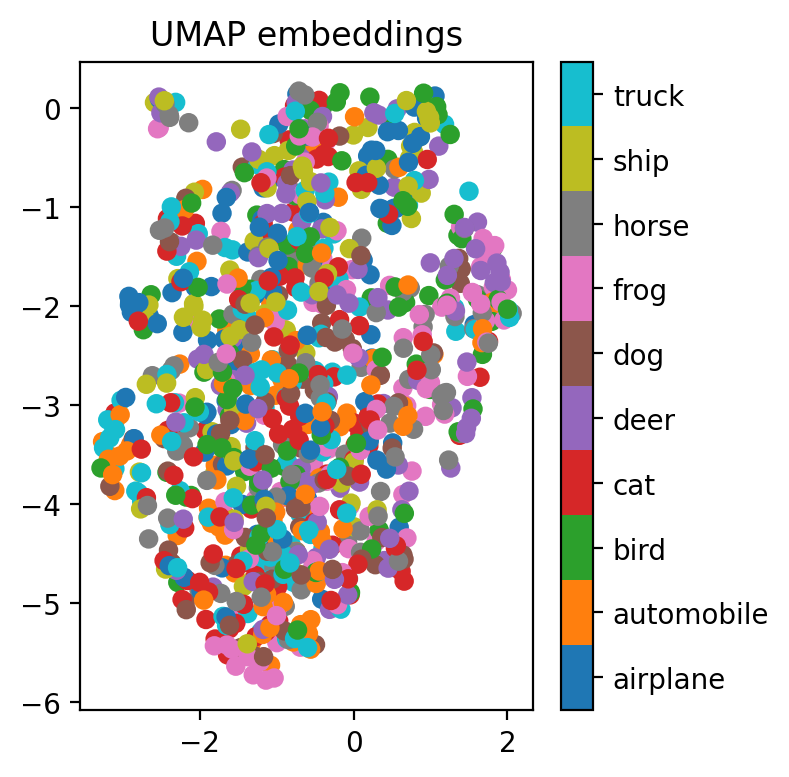

In [13]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

# Train the model on labeled train set(1000)

In [14]:
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(resnet, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

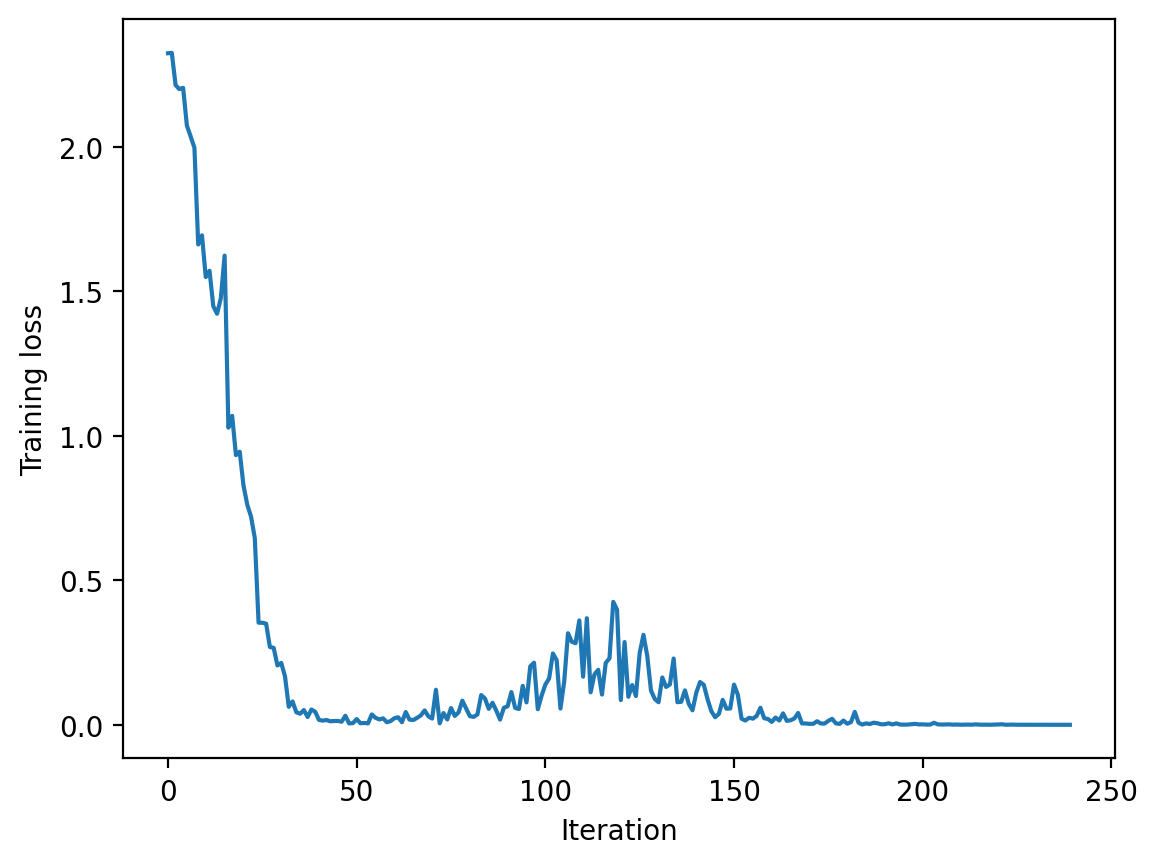

In [15]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


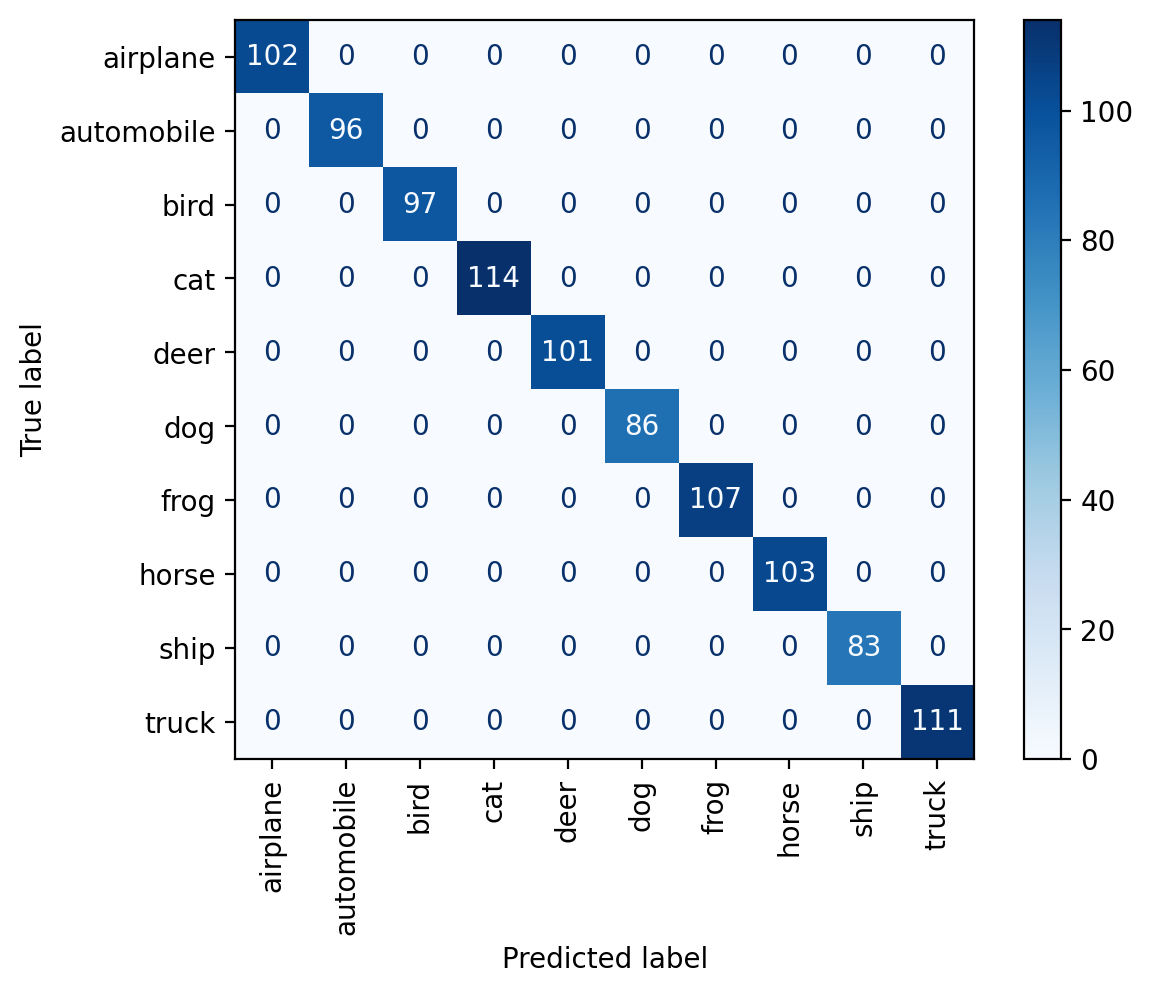

pool set accuracy: 36.05%


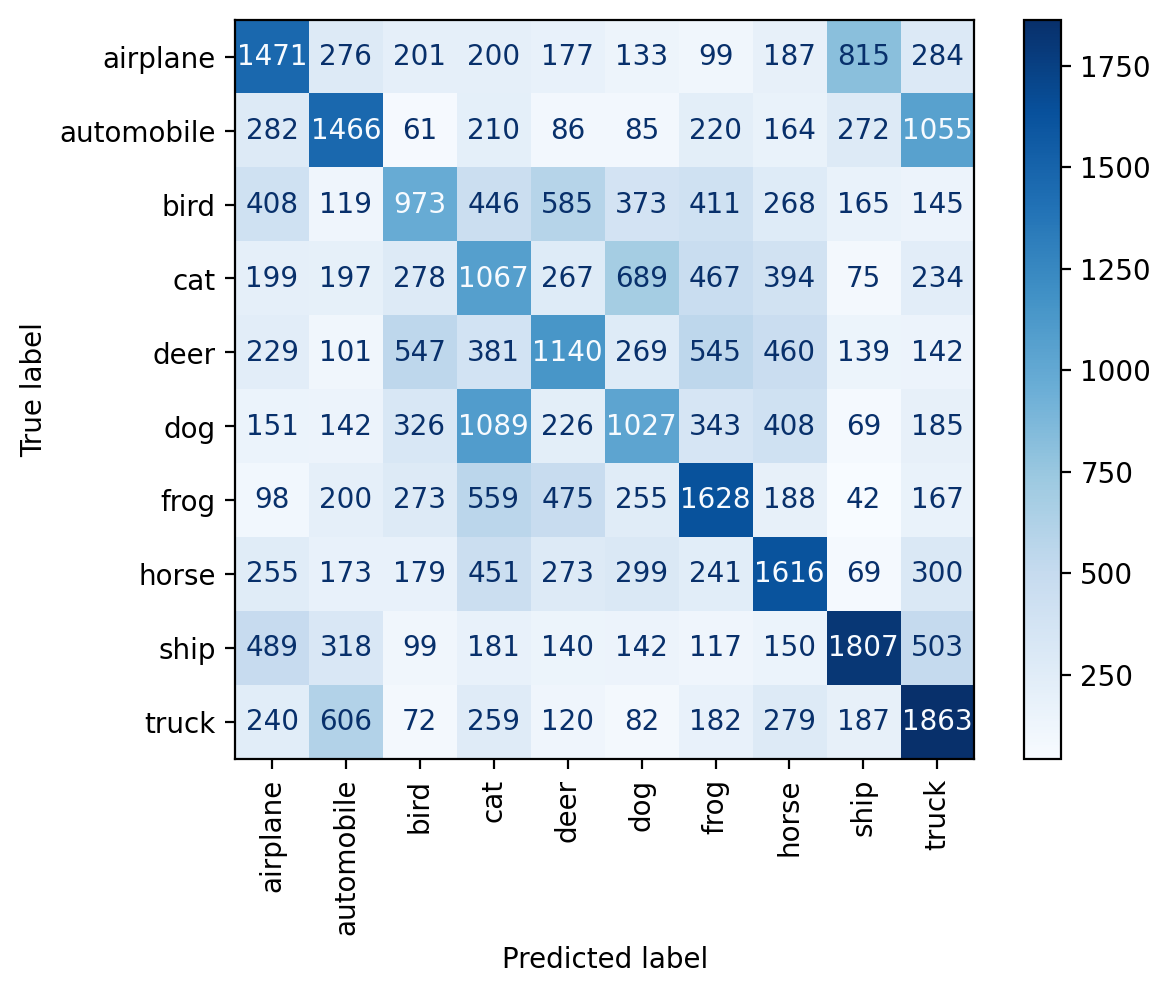

test set accuracy: 35.65%


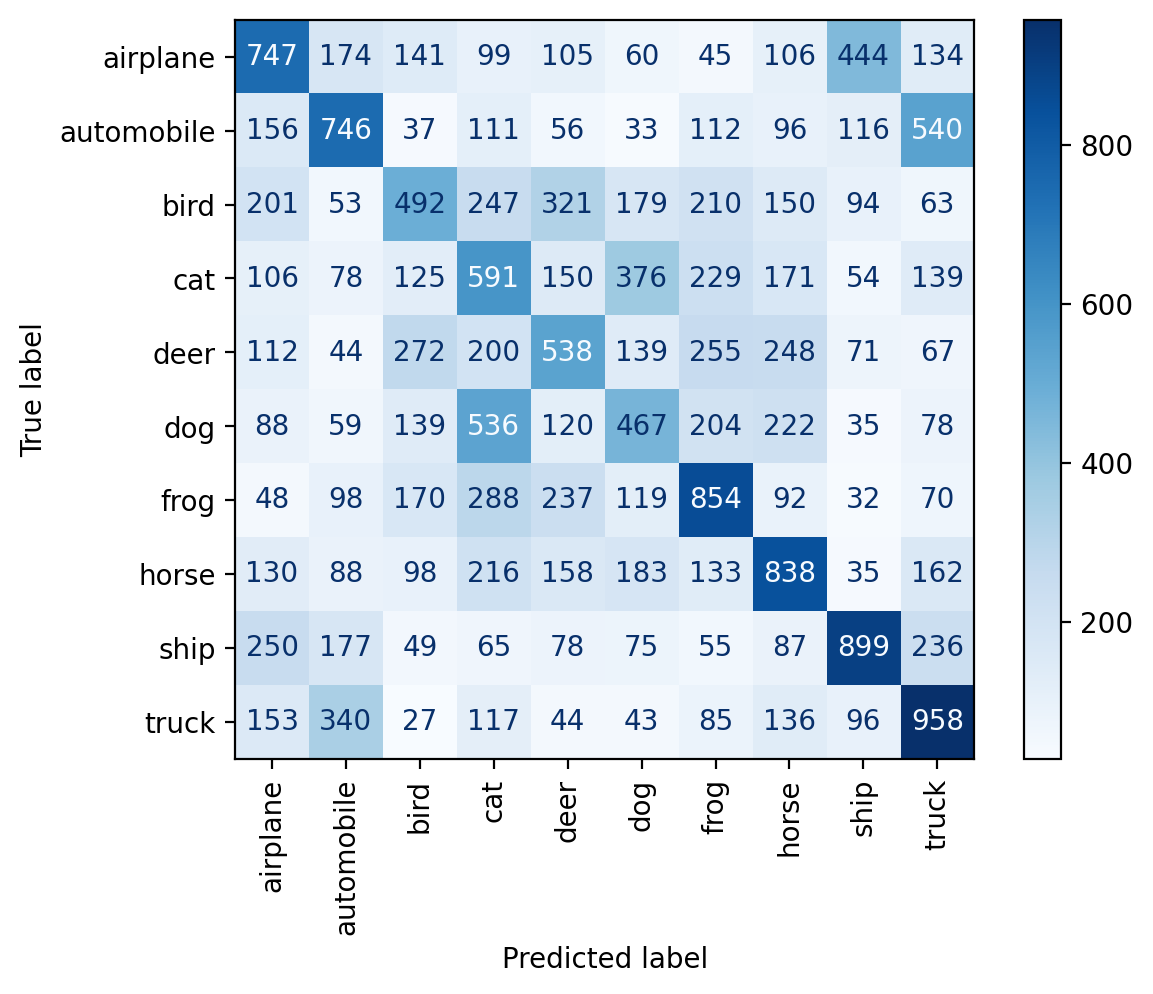

In [16]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


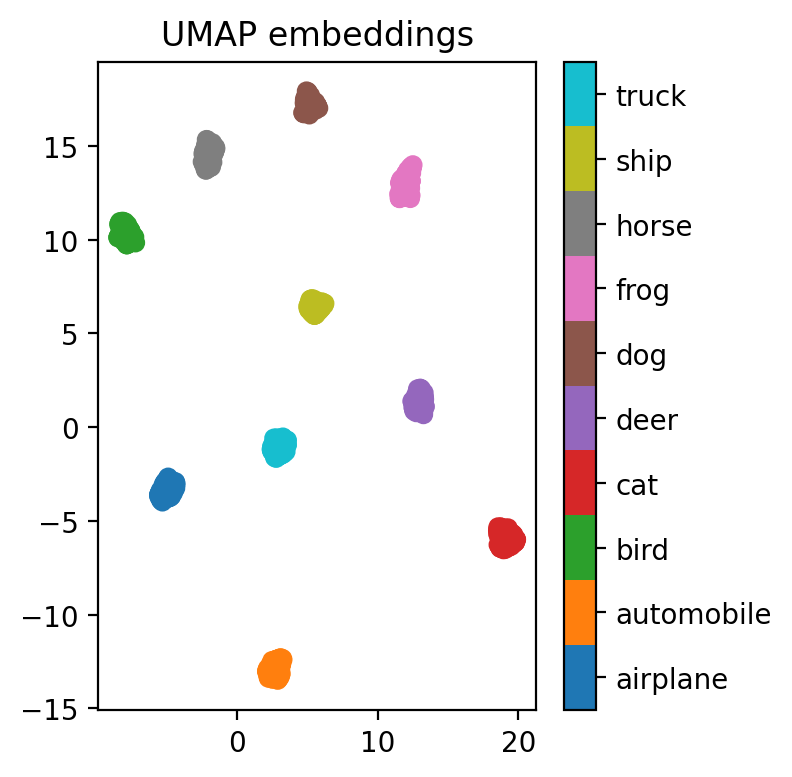

In [17]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

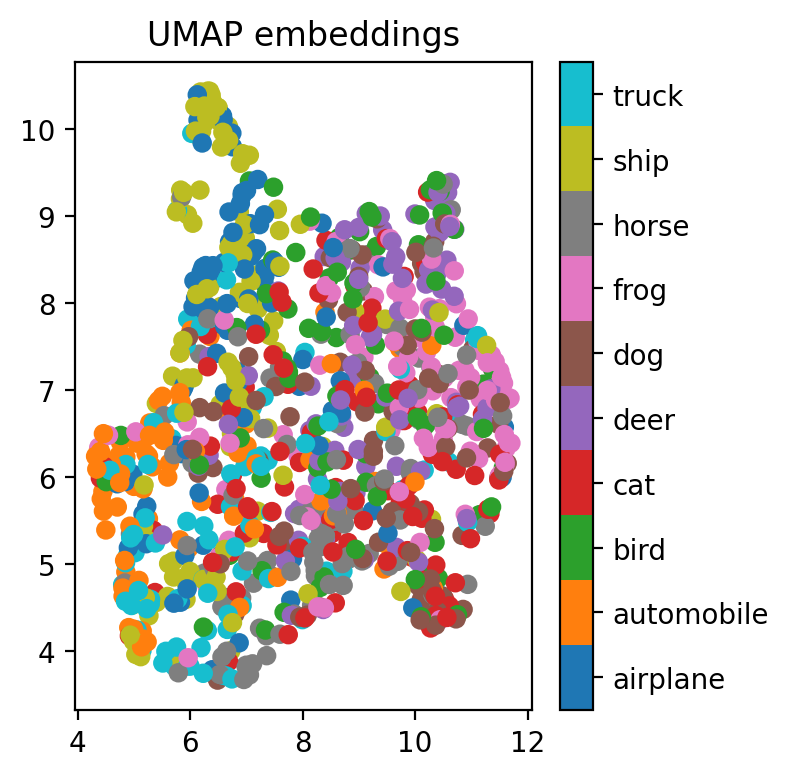

In [18]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

# Train on train labeled(1000)+ labeled pool(5000)

In [19]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx[:5000]])
print(train_plus_pool_idx.shape)
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30, verbose=False)

torch.Size([6000])


Text(0, 0.5, 'Training loss')

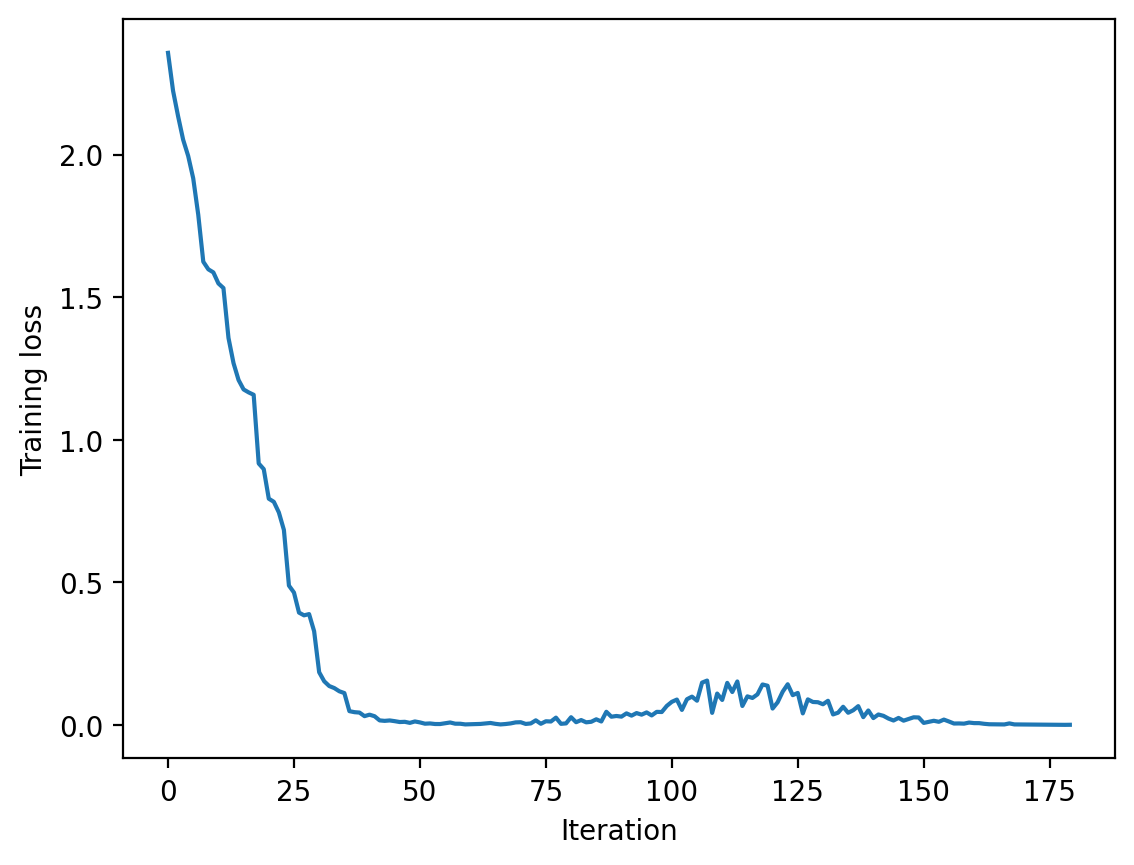

In [20]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss") 

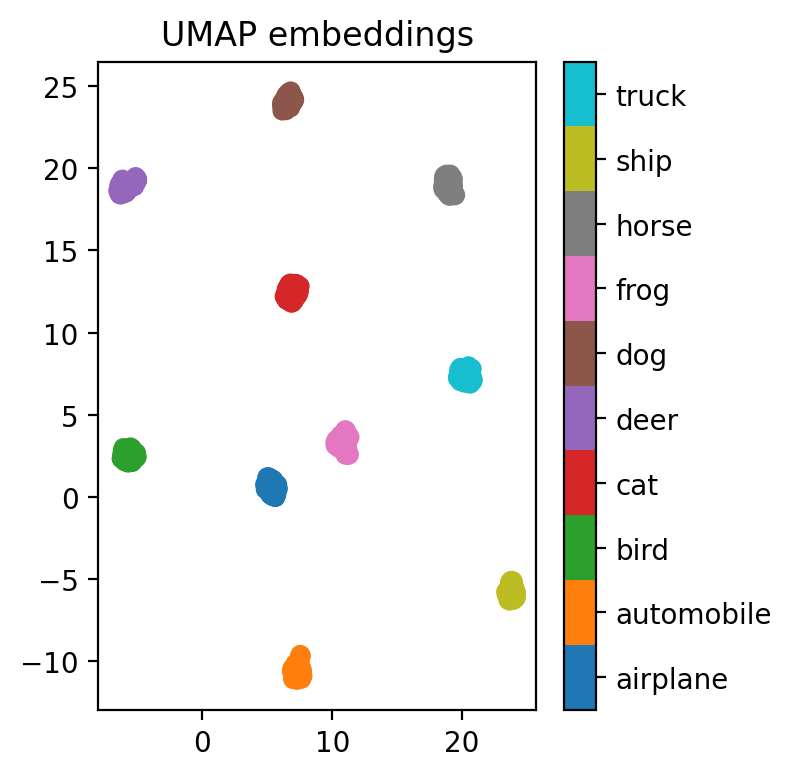

In [21]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

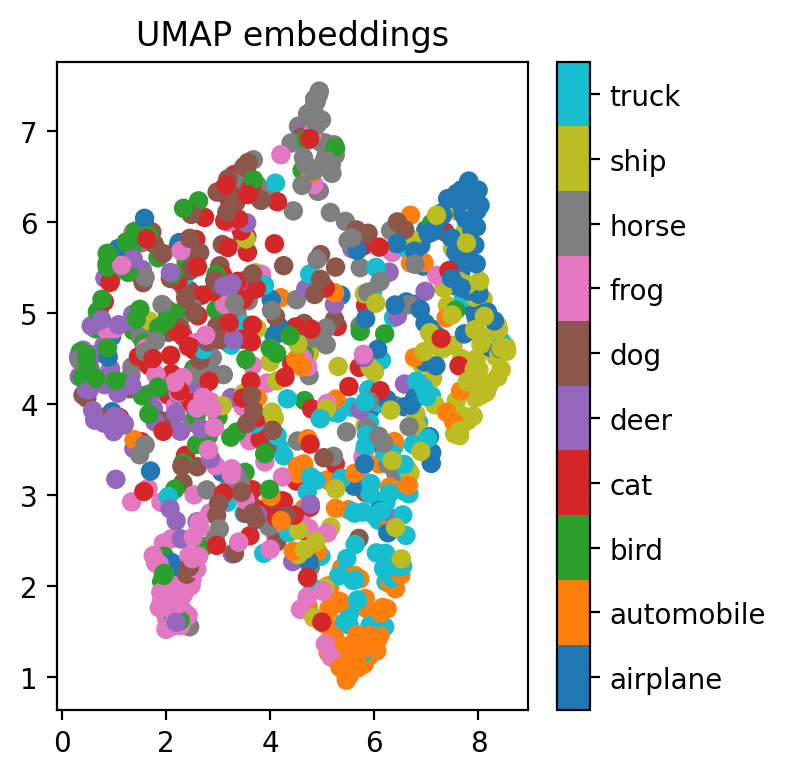

In [22]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%


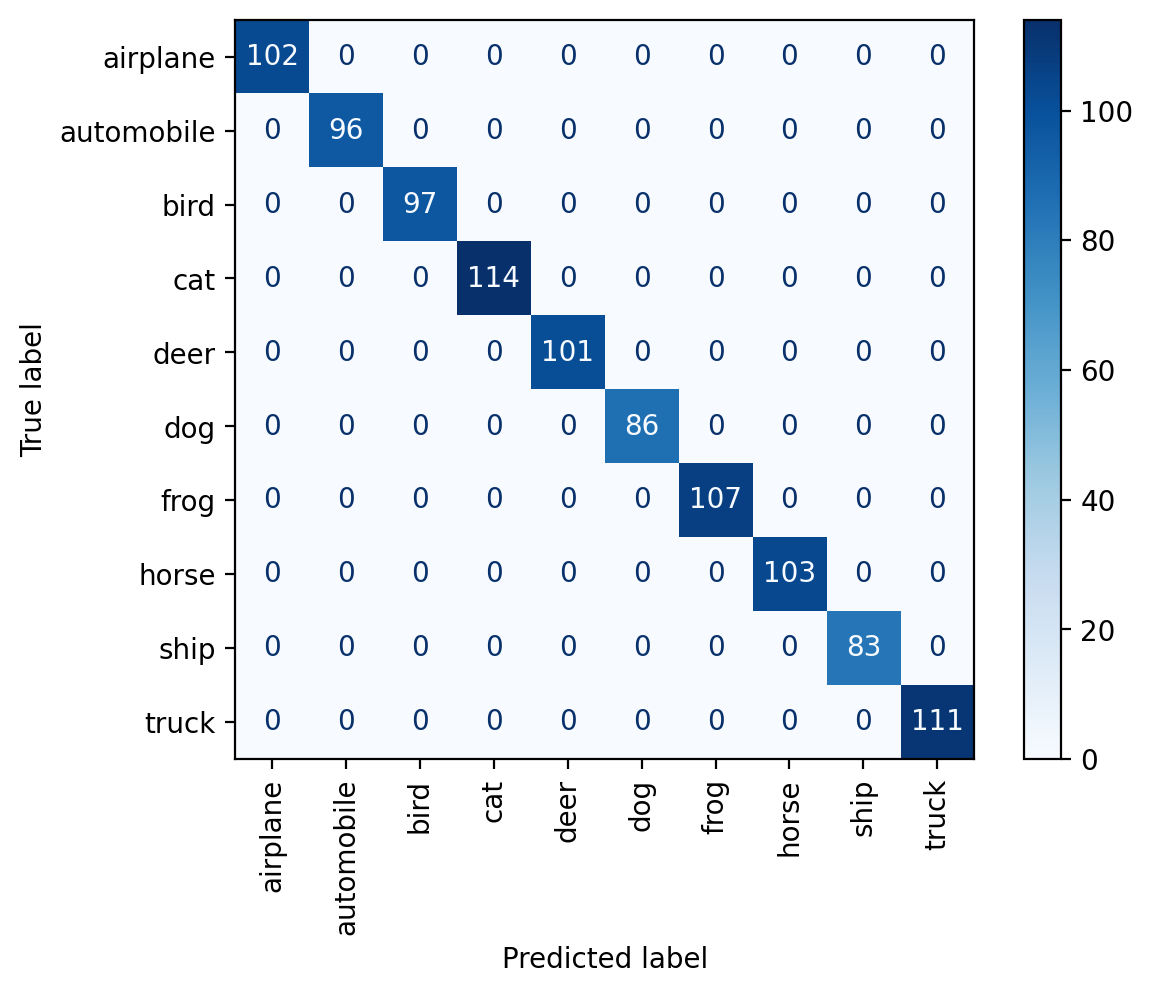

pool set accuracy: 51.38%


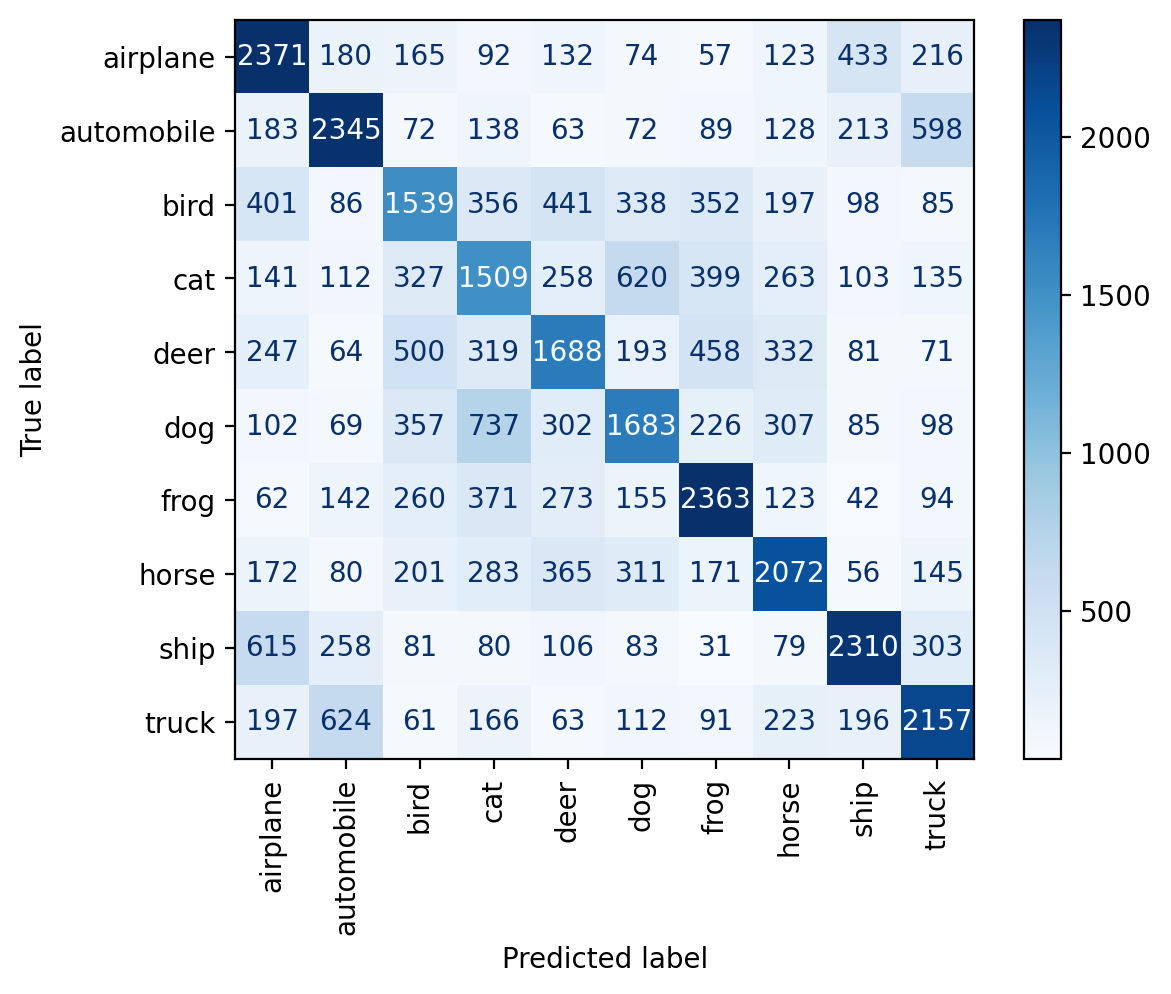

test set accuracy: 43.62%


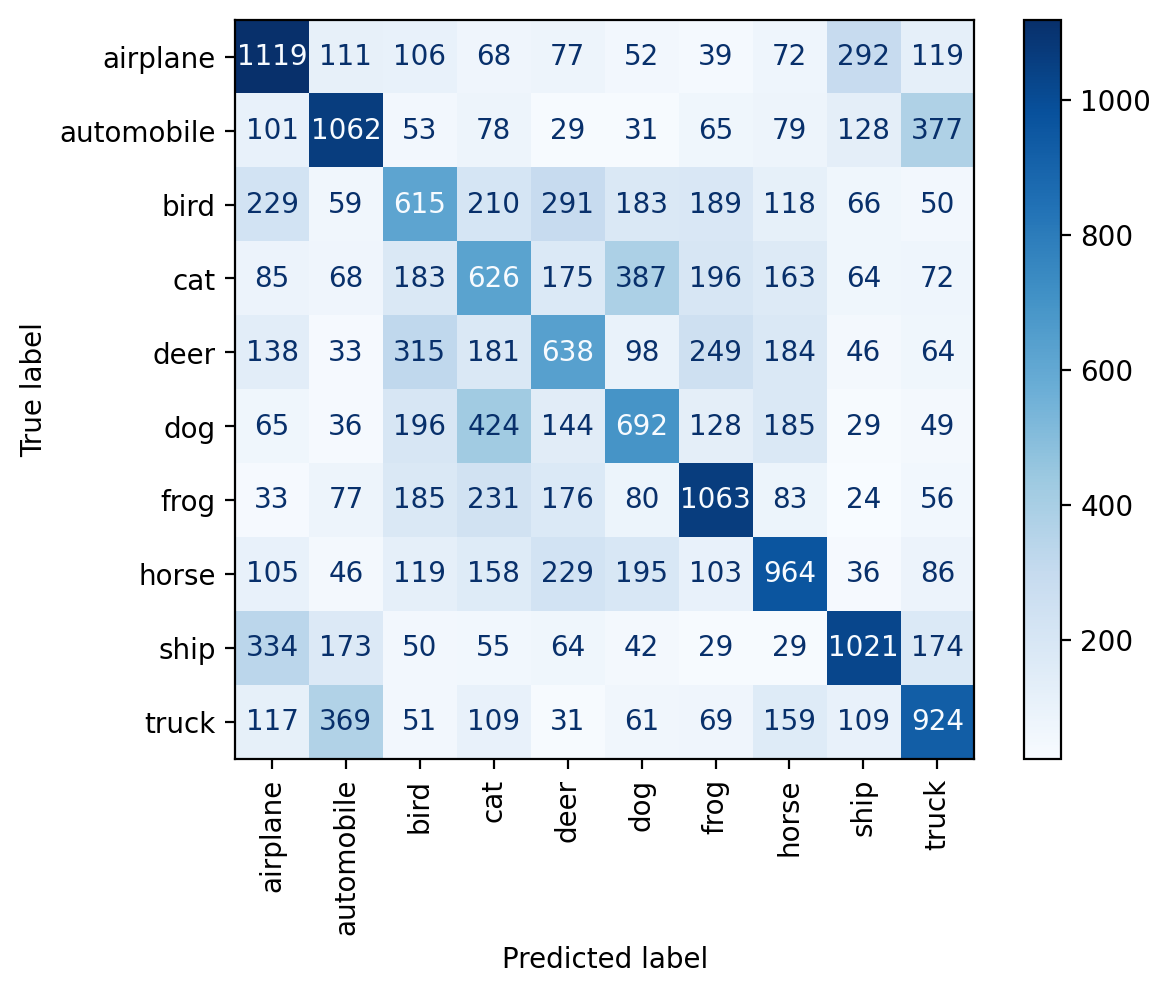

In [23]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

# Train on labled train(1000) + labeled pool whole(39000)

In [24]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

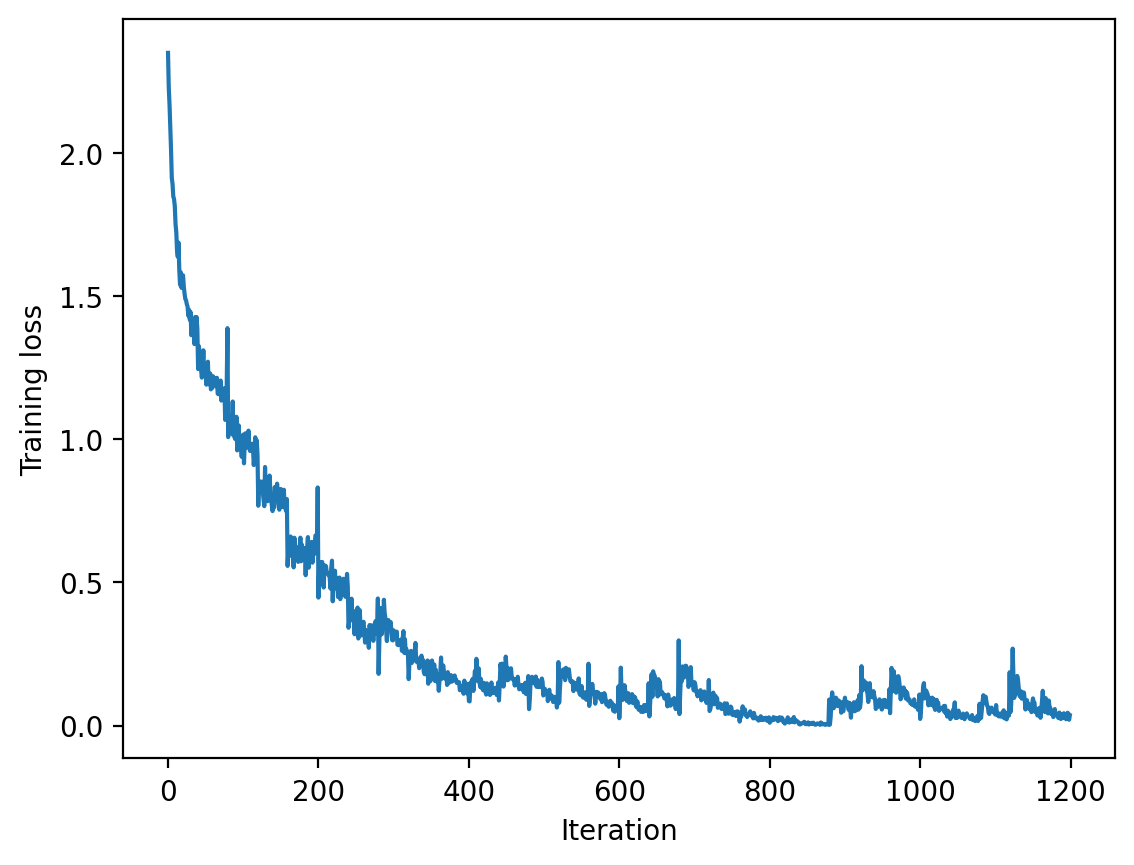

In [25]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss")

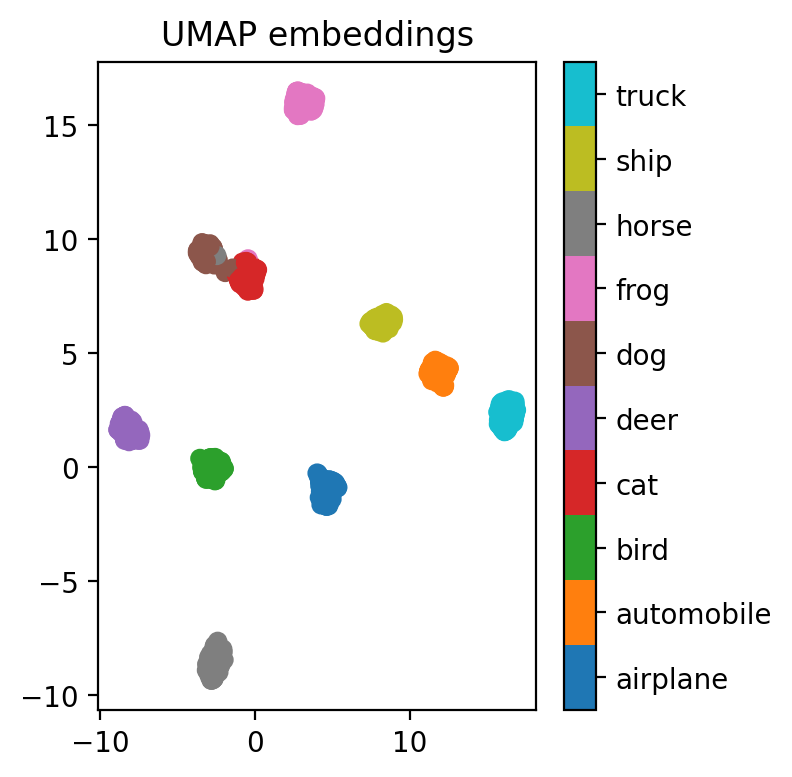

In [26]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

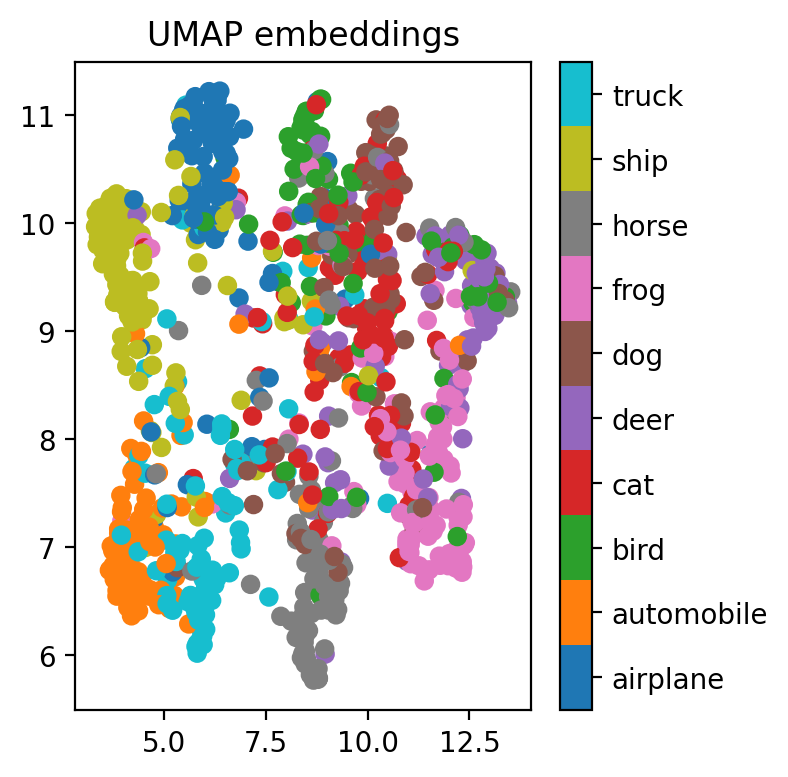

In [27]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.50%


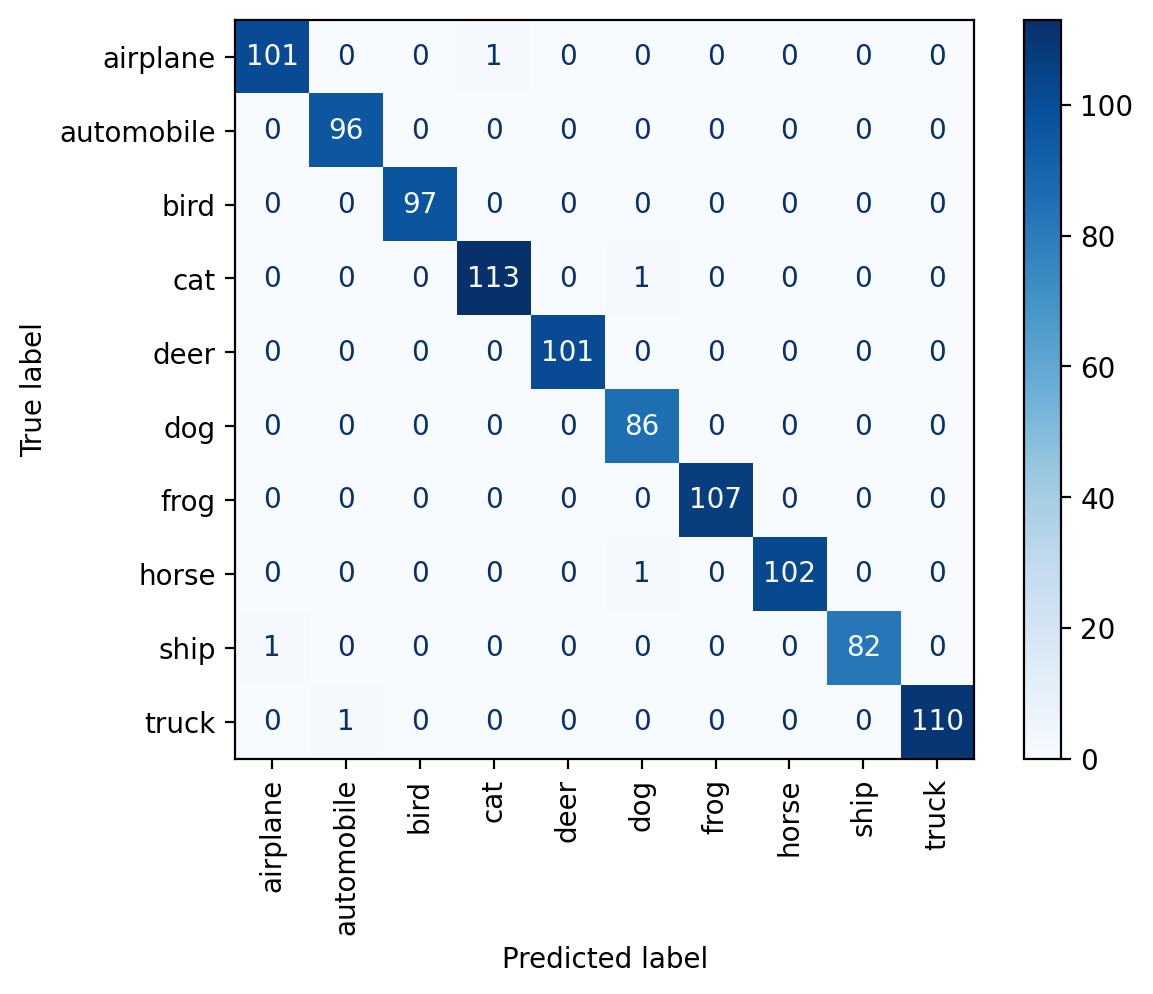

pool set accuracy: 99.66%


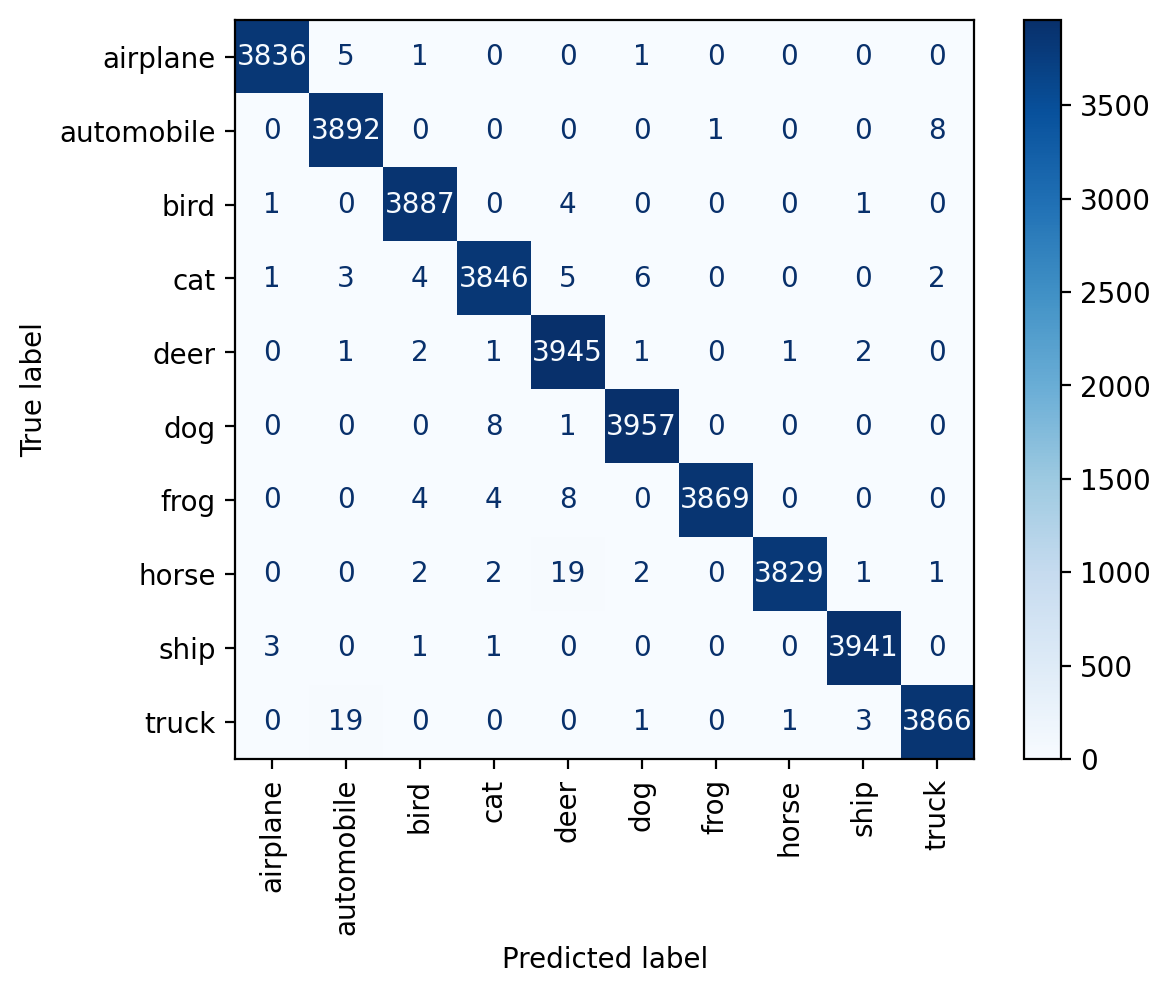

test set accuracy: 63.02%


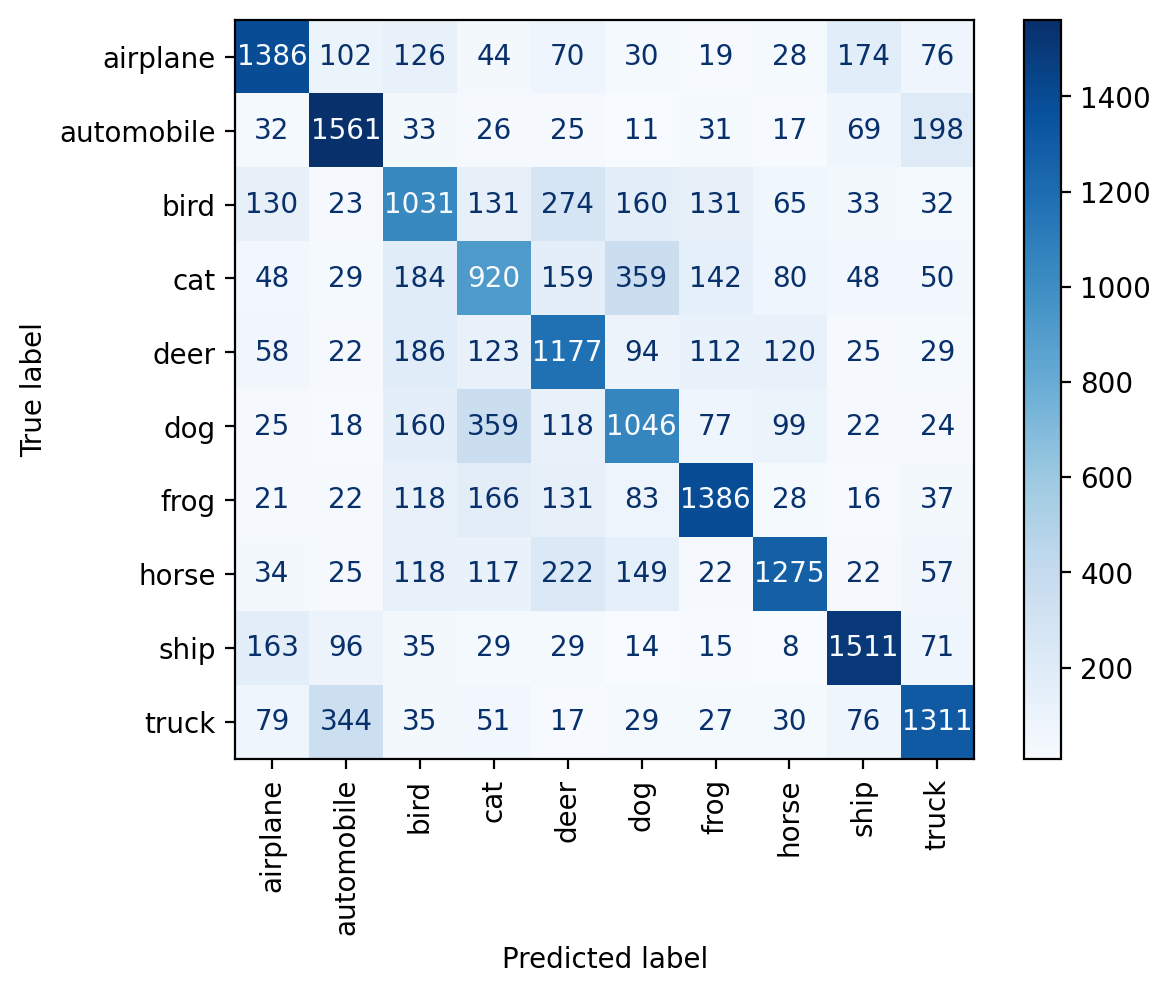

In [28]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

# Active Learning for Convolutional Neural Networks: A Core-Set Approach
Paper [link](https://arxiv.org/abs/1708.00489)

In [29]:
acquisition = Furthest()
strategy = DiversityStrategy(acquisition, X, y)
# Put the strategy on the device
strategy.to(device)

DiversityStrategy()

In [30]:
train_idx_copy = train_idx.clone()
pool_idx_copy = pool_idx.clone()

n_query_samples = 100 # Number of samples to add to training set at each iteration
num_iter = 50 # Number of iterations to run active learning for
accuracy_list = [] # List to store accuracies
for i in trange(num_iter):
    resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
    iter_losses, epoch_losses = train_fn(resnet, X[train_idx_copy], y[train_idx_copy], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

    best_indices = strategy.query(
        resnet.featurizer, pool_idx_copy.to(device), train_idx_copy.to(device), n_query_samples=n_query_samples
    )
    train_idx_copy = torch.cat([train_idx_copy, pool_idx_copy[best_indices[acquisition.__class__.__name__]]])
    
    # print(f"Selected indices: {pool_idx_copy[best_indices[acquisition.__class__.__name__]]}")
    pool_idx_copy = torch.cat([pool_idx_copy[i:i + 1] for i in range(len(pool_idx_copy)) if i not in best_indices[acquisition.__class__.__name__]], dim=0)
    y_pred, acc = get_accuracy(resnet, X[test_idx], y[test_idx])
    accuracy_list.append(acc)
print(train_idx_copy.shape, pool_idx_copy.shape)
selected_idx = train_idx_copy 

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [11:26<00:00, 13.74s/it]

torch.Size([6000]) torch.Size([34000])


In [31]:
accuracy_list[0], accuracy_list[-1] # Initial and final accuracy

(tensor(0.3677, device='cuda:0'), tensor(0.4789, device='cuda:0'))

train set accuracy: 96.90%


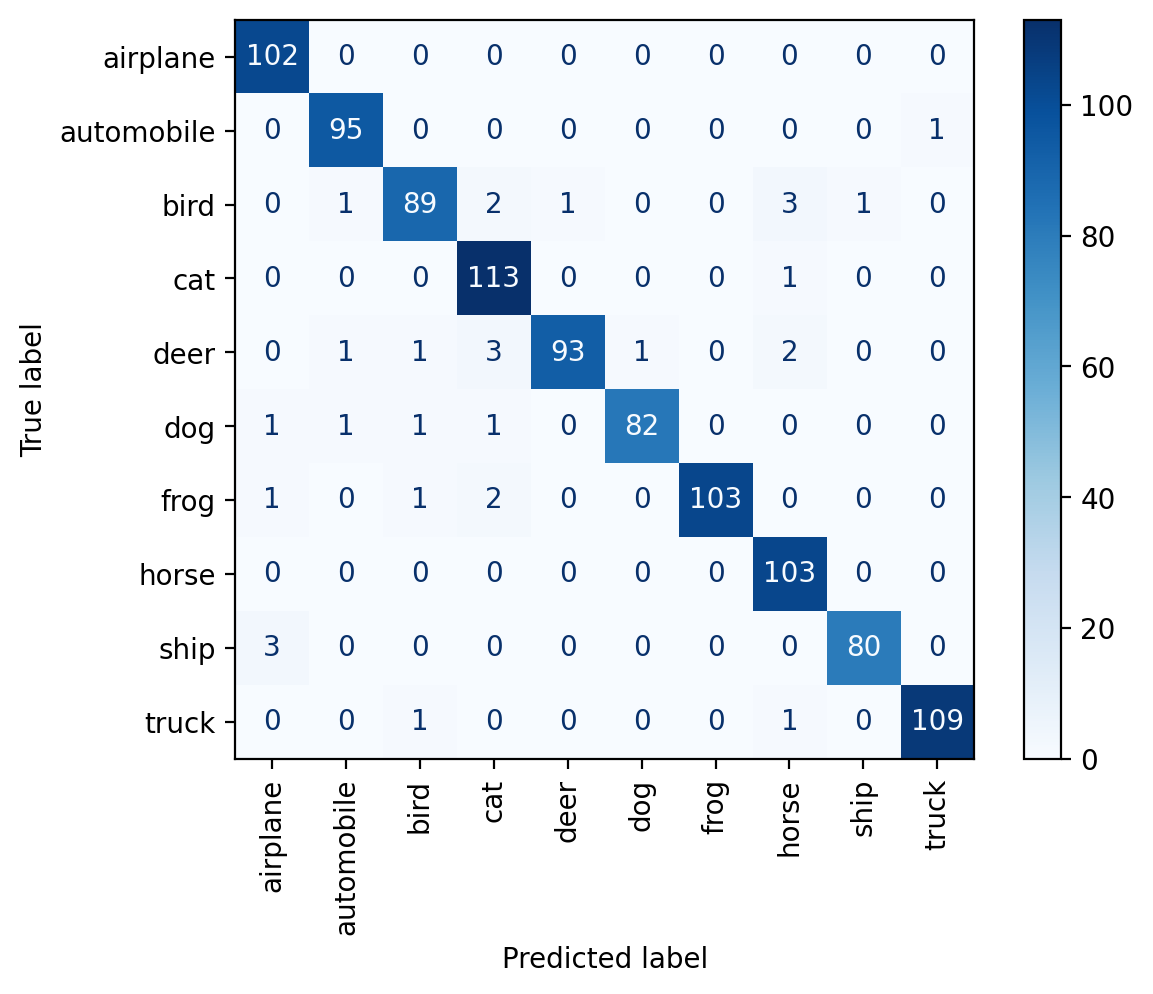

pool set accuracy: 53.18%


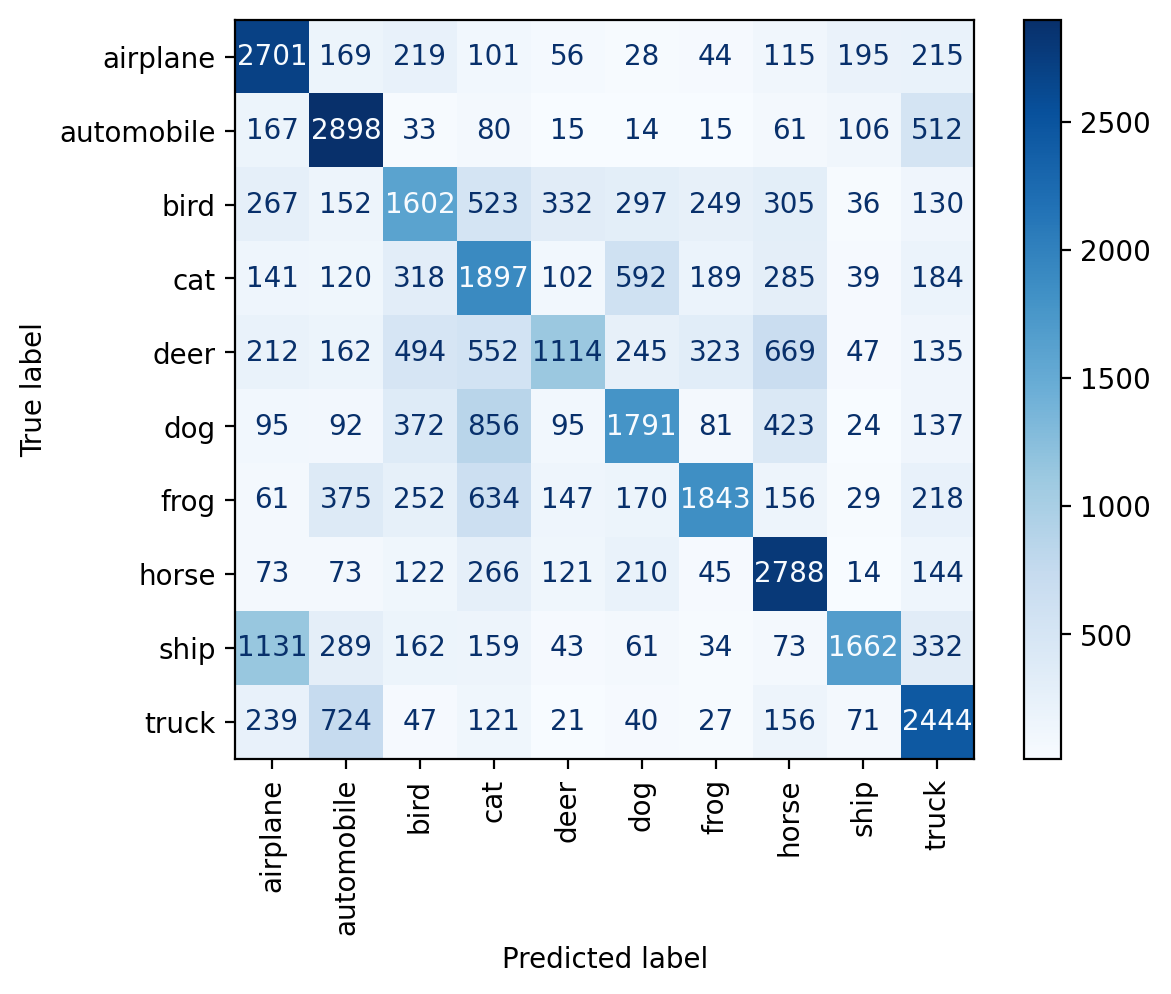

test set accuracy: 47.92%


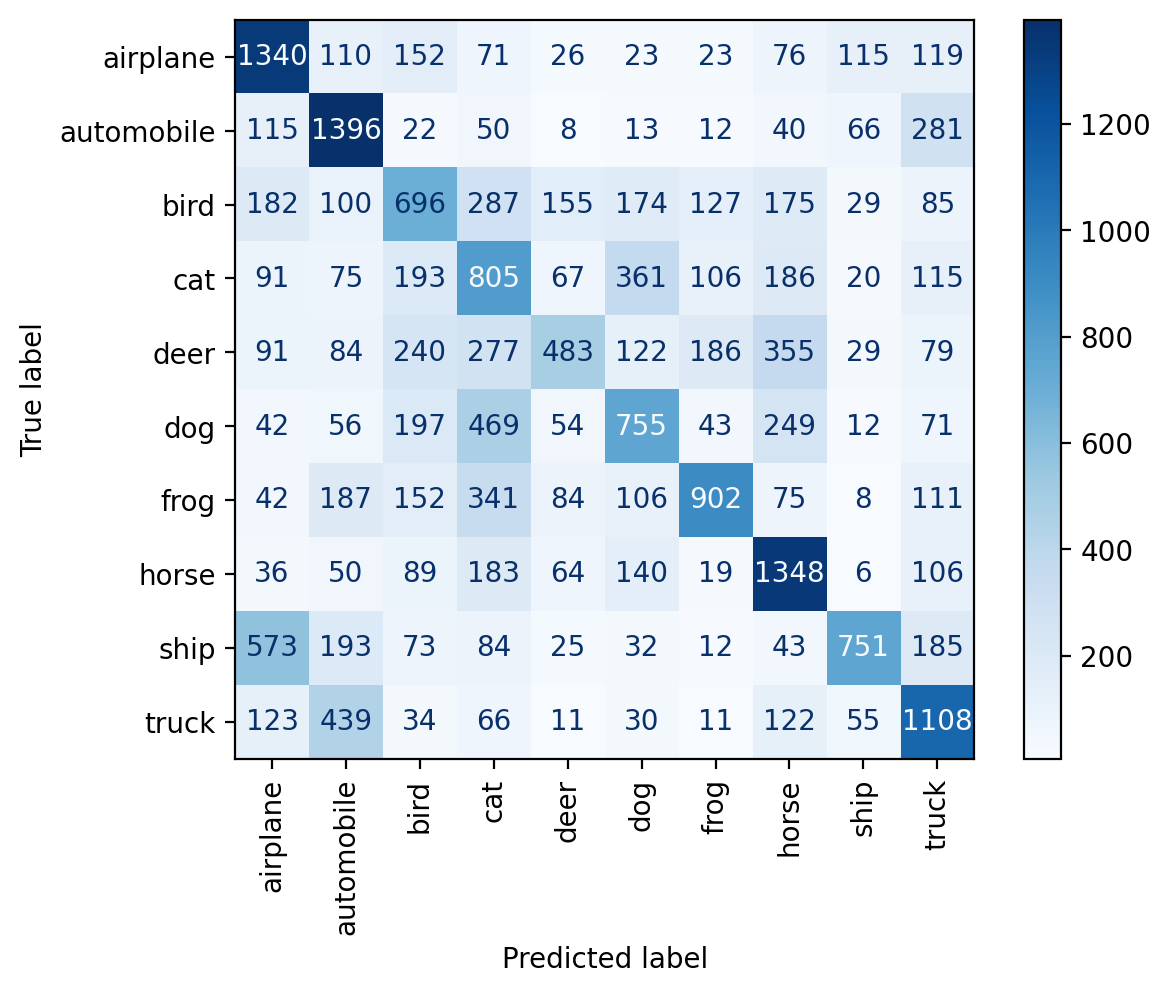

In [32]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

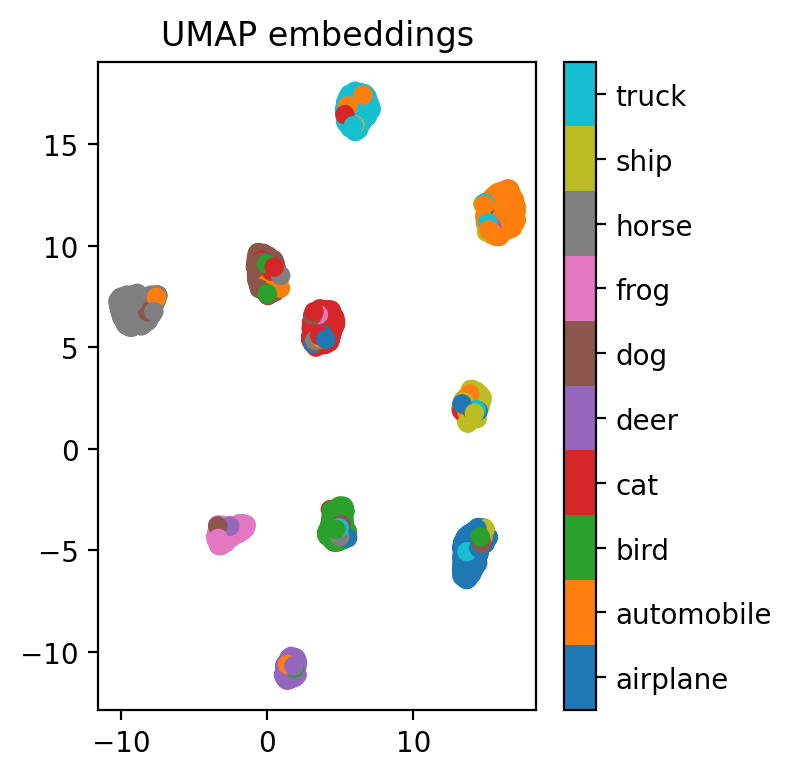

In [33]:
viz_embeddings(resnet, X[train_idx_copy], y[train_idx_copy], device)

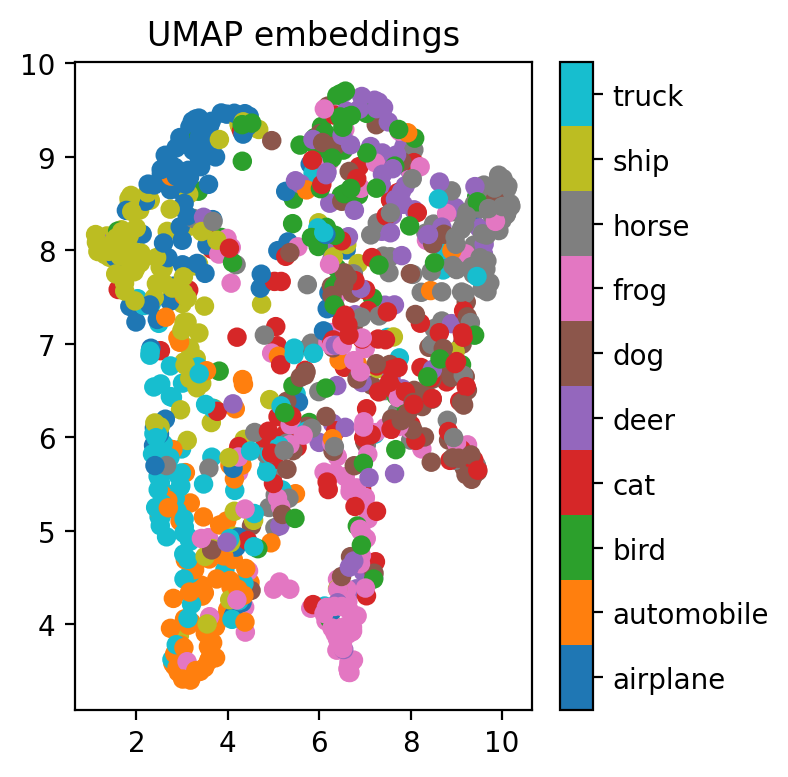

In [34]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

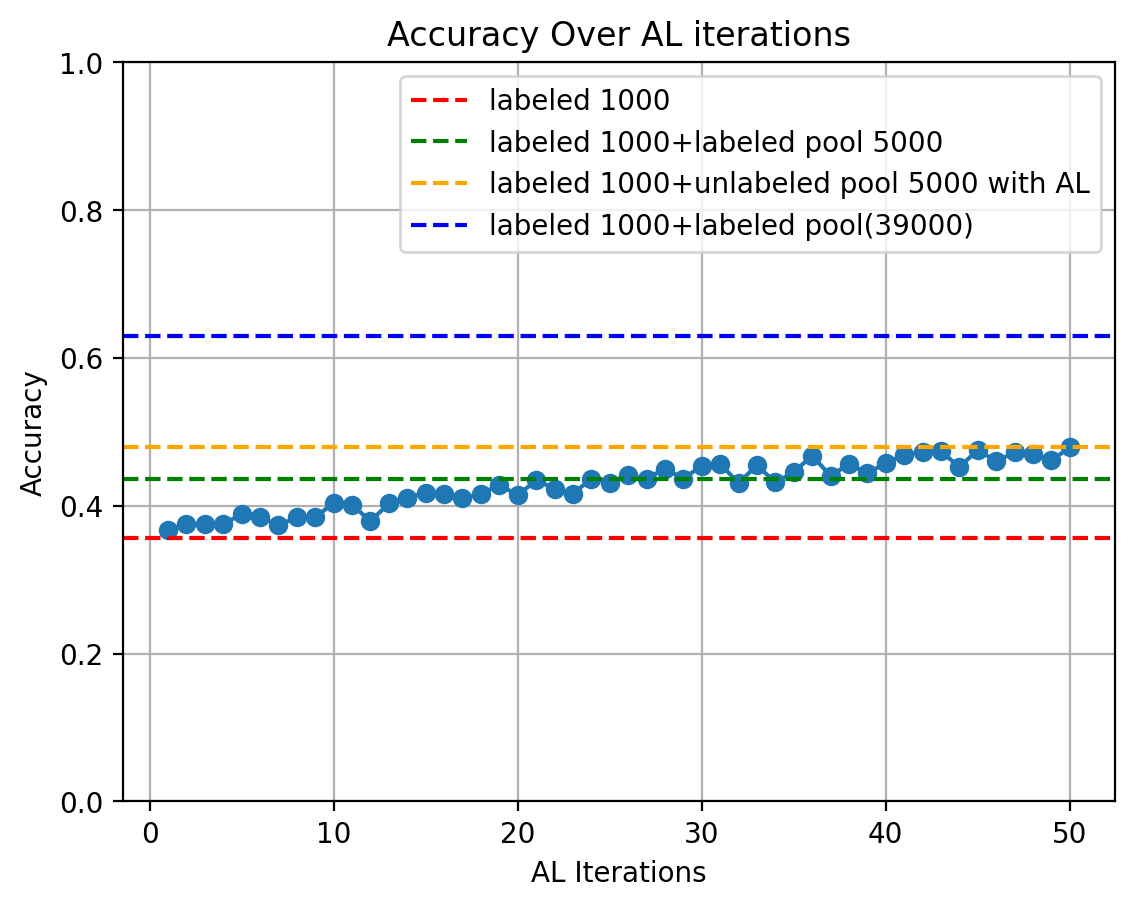

In [38]:
accuracy_values = [acc.item() for acc in accuracy_list]

# Create a list of epochs (you can adjust this as needed)
epochs = range(1, len(accuracy_values) + 1)

# Create the plot
plt.plot(epochs, accuracy_values, marker='o', linestyle='-')
plt.axhline(y=0.3565, color='red', linestyle='--', label='labeled 1000')
plt.axhline(y=0.4362, color='green', linestyle='--', label='labeled 1000+labeled pool 5000')
plt.axhline(y=0.4792, color='orange', linestyle='--', label='labeled 1000+unlabeled pool 5000 with AL')
plt.axhline(y=0.6302, color='blue', linestyle='--', label='labeled 1000+labeled pool(39000)')

plt.legend()
plt.title('Accuracy Over AL iterations')
plt.xlabel('AL Iterations')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

### Summary of our experiments
Accuracy on test set
- Untrained model : 8.58%
- Trained model on train(1000) labeled : 35.65%
- Trained model on train(1000) labeled + pool set(5000)  labeled: 43.62%
- Trained model on train(1000) labeled + pool set(5000)  unlabeled selected by AL 47.92%
  - Here we used the core-set approach to select the unlabeled data from the pool set
  - We pick 100 data points for each iteration from the pool set which are farthest from the train set for 50 such AL iterations
- Trained model on train(1000) labeled + pool set(39000) labeled: 63.02%

all above are trained on 30 epochs